In [1]:
import pandas as pd
from cleaning import create_demand
import pyomo.environ as pyo
import pyomo

# Data import

In [2]:
nodes = pd.read_pickle("../../data/original/nodes.pkl")
channels = pd.read_pickle("../../data/original/channels.pkl")

## Modeling

In [3]:
pyomo.common.timing.report_timing()

In [4]:
# Multiplication to set the same base unit for all computations
channels["capacity"] = channels["capacity"] * 1000000
channels["base_fee"] = channels["base_fee"] * 1000000

In [5]:
model = pyo.ConcreteModel(name="Min cost flow problem")
model.NODES = pyo.Set(initialize=nodes.index)
model.CHANNELS = pyo.Set(initialize=[(channels.loc[i, "node1_pub"], channels.loc[i, "node2_pub"]) for i in channels.index])

           0 seconds to construct Block ConcreteModel; 1 index total
        0.03 seconds to construct Set NODES; 1 index total
        0.45 seconds to construct Set CHANNELS; 1 index total


In [6]:
transaction_amount = 1000000
nodes = create_demand(nodes, transaction_amount,
                      source="02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3",destination="0202f00d5f5c91a3c79113851b162c2b75f2cbd9fb2378fb4a4ce92d5ba1e63e08")

Transaction of 1000000 sats.
Sender: VeniceForever
Receiver: ShatSat412.


In [7]:
model.x = pyo.Var(model.CHANNELS, domain=pyo.NonNegativeIntegers, bounds=(0,1))
model.a = pyo.Var(model.CHANNELS, domain=pyo.NonNegativeReals, bounds=(0, max(nodes["demand"])))

        0.14 seconds to construct Var x; 89898 indices total
        0.14 seconds to construct Var a; 89898 indices total


In [8]:
channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True)

### Objective function

$$
min \sum_{} ^{} amount_i \times feerate_{i} + x_{i} \times basefee_{i}
$$

In [9]:
#def objective_function(model: pyo.ConcreteModel):
#    return sum(model.a[i] * channels.loc[i, "rate_fee"] for i in model.CHANNELS) + sum(model.x[i] * channels.loc[i, "base_fee"] for i in model.CHANNELS)

def objective_function(model: pyo.ConcreteModel):
    return sum(model.a[i] * channels.loc[i, "rate_fee"] + model.x[i] * channels.loc[i, "base_fee"] for i in model.CHANNELS)

model.totalCost = pyo.Objective(rule=objective_function(model), sense=pyo.minimize)

           0 seconds to construct Objective totalCost; 1 index total


### Constraints


#### Capacity constraint

$$amount_{i,j} \le capacity_{i,j} \times x_{i,j} \text{ } \forall (i,j) \in E$$

In [10]:
def capacity_constraint(model: pyo.ConcreteModel, a, b):
    return model.a[(a, b)] <= channels.loc[(a, b), "capacity"] * model.x[(a, b)]

model.CapacityConstraint = pyo.Constraint(model.CHANNELS, rule=capacity_constraint, name="Capacity constraint")

        5.29 seconds to construct Constraint CapacityConstraint; 89898 indices total


#### Flow balance constraint

$$\sum_{(s,i) \in E} amount_{s,i} - \sum_{(i,t) \in E} amount_{i,d} = b_i \text{ } \forall i \in V$$

where $s$ is the source node, $d$ is the destination node, $i$ is every intermediary node


In [11]:
channels.reset_index(inplace=True)
channels.set_index("channel_id", inplace=True)

def flow_balance_constraint(model: pyo.ConcreteModel, n: str):
    InFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'incoming_channels'])
    OutFlow = sum(model.a[(channels.loc[a, "node1_pub"], channels.loc[a, "node2_pub"])] for a in nodes.loc[n, 'outgoing_channels'])
    return  OutFlow + nodes.loc[n, "demand"] == InFlow

model.FlowBalanceConstraint = pyo.Constraint(model.NODES, rule=flow_balance_constraint, name="Flow balance constrain")

channels.reset_index(inplace=True)
channels.set_index(["node1_pub", "node2_pub"], inplace=True)
channels.sort_index(inplace=True) 

        3.25 seconds to construct Constraint FlowBalanceConstraint; 11984 indices total


## Solving the model

In [12]:
#from pyomo.common.tempfiles import TempfileManager
#TempfileManager.tempdir = "/home/filippo/repositories/LN-pathfinding"

In [13]:
opt = pyo.SolverFactory('cbc')
#opt = pyo.SolverFactory('cplex_direct')
results = opt.solve(model, tee=True, keepfiles=True)

if (results.solver.status == pyo.SolverStatus.ok) and (results.solver.termination_condition == pyo.TerminationCondition.optimal):
    print('\nOptimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.feasible:
    print('\nFeasible but not proven optimal solution found')
elif results.solver.termination_condition == pyo.TerminationCondition.infeasible:
    raise Exception("The model is infeasible")
else:
    print('\nSolver Status: ',  results.solver.status)
    raise Exception(results.solver.status)

print('\nObject function value = ', model.Objective())


           0 seconds to construct Var ONE_VAR_CONSTANT; 1 index total
      [    2.02] Generated LP representation
Solver log file: '/tmp/tmp3z2gd88f.cbc.log'
Solver solution file: '/tmp/tmp0gsd1yq0.pyomo.soln'
Solver problem files: ('/tmp/tmp0gsd1yq0.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.10.8 
Build Date: May  9 2022 

command line - /usr/bin/cbc -printingOptions all -import /tmp/tmp0gsd1yq0.pyomo.lp -stat=1 -solve -solu /tmp/tmp0gsd1yq0.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 61043 (-40839) rows, 138206 (-41590) columns and 265393 (-93649) elements
Statistics for presolved model
Original problem has 89898 integers (89898 of which binary)
Presolved problem has 55058 integers (55058 of which binary)
==== 6362 zero objective 3865 different
==== absolute objective values 3865 different
==== for integers 0 zero objective 967 different
==== for integers absolute objective values 967 different
===== end objective counts

In [14]:
#from pyomo.opt import SolverStatus, TerminationCondition

print("Solver Status: ",  results.solver[0]["System time"])


Solver Status:  6.48


In [15]:
from decimal import Decimal
pd.set_option('display.max_colwidth', 10000000000000000000000000000000000000000000000000000)
DF_channels = pd.DataFrame()
c = 0
for index, value in model.a.extract_values().items():
    if value > 0.1:
        DF_channels.loc[c, "source"] = index[0]
        DF_channels.loc[c, "destination"] = index[1]
        try:
            DF_channels.loc[c, "source-alias"] = nodes.loc[index[0], "alias"]
        except KeyError:
            print("Source alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "source-alias"] = "source-alias"
            pass
        try:
            DF_channels.loc[c, "destination-alias"] = nodes.loc[index[1], "alias"]
        except KeyError:
            print("Destination alias not found in nodes database: placeholder inserted")
            DF_channels.loc[c, "destination-alias"] = "destination-alias"
            pass
        DF_channels.loc[c, "capacity"] = Decimal(channels.loc[index, "capacity"]/1000000)
        DF_channels.loc[c, "amount"] = Decimal(value/1000000)
        DF_channels.loc[c, "base_fee"] = Decimal(channels.loc[(index[0], index[1]), "base_fee"]/1000000)
        DF_channels.loc[c, "rate_fee"] = channels.loc[(index[0], index[1]), "rate_fee"]
        #DF_channels.loc[c, "used_fl"] = channels.loc[]
        c += 1

DF_channels_pos = DF_channels[DF_channels["amount"]!=0]

In [16]:
DF_channels[DF_channels["amount"]> DF_channels["capacity"]]

,source,destination,source-alias,destination-alias,capacity,amount,base_fee,rate_fee


In [17]:
DF_fixed = pd.DataFrame()
c = 0
for index, value in model.x.extract_values().items():
    if value != 0:
        DF_fixed.loc[c, "source"] = index[0]
        DF_fixed.loc[c, "destination"] = index[1]
        DF_fixed.loc[c, "used"] = Decimal(value)
        c += 1

DF_fixed_pos = DF_fixed[DF_fixed["used"]!=0]
DF_fixed_pos

,source,destination,used
0,0200000000a3eff613189ca6c4070c89206ad658e286751eca1f29262948247a5f,02e4971e61a3f55718ae31e2eed19aaf2e32caf3eb5ef5ff03e01aa3ada8907e78,1
1,0200000000a3eff613189ca6c4070c89206ad658e286751eca1f29262948247a5f,02f1a8c87607f415c8f22c00593002775941dea48869ce23096af27b0cfdcc0b69,1
2,020003b9499a97c8dfbbab6b196319db37ba9c37bccb60477f3c867175f417988e,0205198c099c45acedf988445f71da087ca39cd80847e53a7819e8f4e45768d7d3,1
3,020003b9499a97c8dfbbab6b196319db37ba9c37bccb60477f3c867175f417988e,0208dfa005c47a8ae85363d12c54007a38550ca0d6f1c559ee11caaac8221eccd6,1
4,020003b9499a97c8dfbbab6b196319db37ba9c37bccb60477f3c867175f417988e,020f7c502e19ccb375d4abc689f2c1feb6816961d4a1e2dcfa8813f11c3bc9a5e1,1
...,...,...,...
34824,03ffb24c4740fd13bc69680c4adebba8c332ad63a9a8ee44a541831eeb73d8e72b,0283a2c4416a4803590d46fc104a8df50455c84cb25e9efe494b3ad4739bb5b3f7,1
34825,03ffb24c4740fd13bc69680c4adebba8c332ad63a9a8ee44a541831eeb73d8e72b,0324ba2392e25bff76abd0b1f7e4b53b5f82aa53fddc3419b051b6c801db9e2247,1
34826,03ffb24c4740fd13bc69680c4adebba8c332ad63a9a8ee44a541831eeb73d8e72b,03910da61c1b42e135f134ed92a537c758d1edac5436efbec5ee8cec1928e1a095,1
34827,03ffbc206a416bbf89a7092ac28e7a9e2cd99231f9b4db71f125e38cef8eb4bcda,026a0d374752a27ae489c37d6b37d76d9d7f8ad27a469d091d740018bbfbfdcf3a,1


### All data about channels on path

In [18]:
intersection = DF_fixed_pos.merge(DF_channels_pos, on=["source", "destination"], how="outer")
final = intersection[intersection["amount"]>0]
final

,source,destination,used,source-alias,destination-alias,capacity,amount,base_fee,rate_fee
587,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,034f3f792988c43f41c65a839acdfa48647204bb99aca7de426f7c80b0dcf7a4a6,1,Eprahs,hexagon,1000000,1000000,1,0.0000
5759,0260fab633066ed7b1d9b9b8a0fac87e1579d1709e874d28a0d171a1f5c43bb877,02f0c7b731ca40a285d7c12aa1c5c7c7caa4598d3d6d34904c3714cd0d47852640,1,TangoBolt,Henwen 🐷,10000000,1000000,0,0.0000
6809,026be7f5f2f6649cb9eca52009bb855fc036814da1b703310041966a1912763d91,03e81689bfd18d0accb28d720ed222209b1a5f2c6825308772beac75b1fe35d491,1,Sats4Fun,Rust-eze (now BoltTrustiC),2000000,1000000,0,0.0000
10447,02a98e8c590a1b5602049d6b21d8f4c8861970aa310762f42eae1b2be88372e924,0357853bbdbeda5b662783f391f29bd10194e2254d0f091eb4116a0b405001dd52,1,ed528ad49bedd1f7a638a,SteelRat,16000000,1000000,1,0.0000
11032,02b4098c3116124c0c4105295d3d2e65927d46e98e248d84cb6119da57e4ae31e3,0208d92b2d406094d794b2a6a512f585dbbdee810a870283b9c5bafc4fec8ac0aa,1,VeniceForever,Eprahs,1500000,1000000,1,0.0000
13443,02ddb472c8edf0624dec5544507b705aae67d42a6cc2db133ba7e843fd5ce90135,026be7f5f2f6649cb9eca52009bb855fc036814da1b703310041966a1912763d91,1,AfricaFreeRouting,Sats4Fun,2000000,1000000,0,0.0000
14621,02f0c7b731ca40a285d7c12aa1c5c7c7caa4598d3d6d34904c3714cd0d47852640,03c8e5f583585cac1de2b7503a6ccd3c12ba477cfd139cd4905be504c2f48e86bd,1,Henwen 🐷,Strike,10000000,1000000,0,0.0000
18038,0322d0e43b3d92d30ed187f4e101a9a9605c3ee5fc9721e6dac3ce3d7732fbb13e,02a98e8c590a1b5602049d6b21d8f4c8861970aa310762f42eae1b2be88372e924,1,Megalithic.me,ed528ad49bedd1f7a638a,51000000,1000000,0,0.0000
21624,034f3f792988c43f41c65a839acdfa48647204bb99aca7de426f7c80b0dcf7a4a6,02ddb472c8edf0624dec5544507b705aae67d42a6cc2db133ba7e843fd5ce90135,1,hexagon,AfricaFreeRouting,2000000,1000000,0,0.0000
21967,0357853bbdbeda5b662783f391f29bd10194e2254d0f091eb4116a0b405001dd52,0260fab633066ed7b1d9b9b8a0fac87e1579d1709e874d28a0d171a1f5c43bb877,1,SteelRat,TangoBolt,1000000,1000000,0,0.0000


In [19]:
%%capture --no-stdout
final["amount"] = final["amount"].astype(float)
final["rate_fee"] = final["rate_fee"].astype(float)
final["base_fee"] = final["base_fee"].astype(float)
total_transaction_cost = sum(final["amount"] * final["rate_fee"] + final["base_fee"])
perc_cost = (total_transaction_cost * 100) / transaction_amount
print(f"Transacting {transaction_amount} sats costs {total_transaction_cost} ({perc_cost}% of transaction amount)")

Transacting 1000000 sats costs 104.0 (0.0104% of transaction amount)


/home/filippo/repositories/LN-pathfinding/venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128055 (\N{PIG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


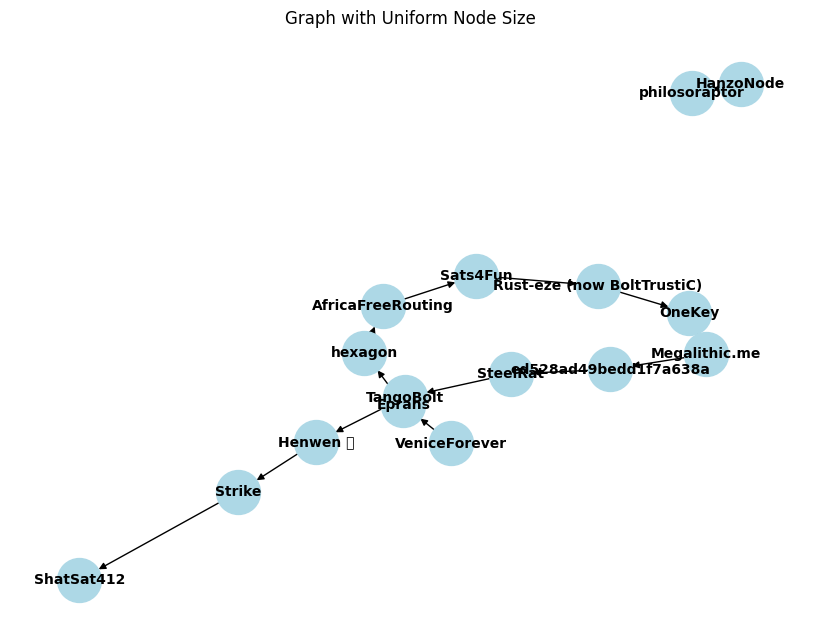

In [20]:
import networkx as nx
import matplotlib.pyplot as plt

# edges list construction
edges_df = final[["source-alias", "destination-alias"]]

G = nx.from_pandas_edgelist(edges_df, "source-alias", "destination-alias", create_using=nx.DiGraph())

#plt.figure(figsize=(8, 6))
#pos = nx.spring_layout(G)
#nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold', arrows=True)
#plt.title("Graph from DataFrame of Edges")
#plt.show()


plt.figure(figsize=(8, 6))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=10, font_color='black', font_weight='bold', arrows=True)
plt.title("Graph with Uniform Node Size")
plt.show()

In [21]:
for i in nx.strongly_connected_components(G):
    print(i)

{'ShatSat412'}
{'Strike'}
{'Henwen 🐷'}
{'TangoBolt'}
{'SteelRat'}
{'ed528ad49bedd1f7a638a'}
{'Megalithic.me'}
{'OneKey'}
{'Rust-eze (now BoltTrustiC)'}
{'Sats4Fun'}
{'AfricaFreeRouting'}
{'hexagon'}
{'Eprahs'}
{'VeniceForever'}
{'HanzoNode', 'philosoraptor'}


In [22]:
final["amount"] = final["amount"].astype(float)
final["rate_fee"] = final["rate_fee"].astype(float)
final["base_fee"] = final["base_fee"].astype(float)
total_transaction_cost = sum(final["amount"] * final["rate_fee"] + final["base_fee"])
perc_cost = (total_transaction_cost * 100) / transaction_amount
print(f"Transacting {transaction_amount} sats costs {total_transaction_cost} ({perc_cost}% of transaction amount)")
print("Solver Status: ", results.solver[0]["System time"])

Transacting 1000000 sats costs 104.0 (0.0104% of transaction amount)
Solver Status:  6.48


/tmp/ipykernel_16039/930812685.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["amount"] = final["amount"].astype(float)
/tmp/ipykernel_16039/930812685.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["rate_fee"] = final["rate_fee"].astype(float)
/tmp/ipykernel_16039/930812685.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.

In [23]:
#from collections import Counter
#results = [tuple(i) for i in DF_channels_pos[["source-alias", "destination-alias"]].to_numpy()]
#unwrap = [e for i in results for e in i]
#extremes = [j for j in unwrap if Counter(unwrap)[j] == 1]
#def return_source(l: list):
#    if l[0] in [i for i, j in results]:
#        return l[0]
#    else: 
#        return l[1]
#sequence = []        
#source = return_source(extremes)
#sequence.append(source)
#while len(sequence) <= len(results):
#    for i,j in results:
#        if i == sequence[-1]:
#            sequence.append(j)
#for i in sequence:
#    print("⬇️", i)